In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import sys
import h5py
import cv2
import warnings
import gc

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from tensorflow import keras

load_dotenv()

sys.path.append("../")

sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


tf.get_logger().setLevel("ERROR")


# Proof of Concept: Determination of the Possibility to Classify Meteorites Based on Their Microscopic Images

- The study will focus on the classes with the largest sample sizes, as they offer enough class support.
- We will test three different models. Due to the limited dataset size, we cannot build a CNN from scratch, as this would likely result in overfitting and the model learning only the training set. Instead, we will use pre-trained ImageNet weights and potentially a BioImage model, which may be better suited for the microscopic imagery.
  
  - **Models**:
    - **VGG19**: A classic baseline model, though it might be simplistic when capturing complex features like textures, contrasts, or sub-elements.
    - **ResNet50**: A more sophisticated model with a better ability to grasp smaller, more detailed features.
    - **ResNet101**: Similar to ResNet50, but with more layers, allowing it to capture more complex features.
  
- Each model will be evaluated using the same dataset and metrics. The goal is to answer the question: "Is it possible to provide sufficiently accurate insights into a meteorite's type based on microscopic observations?"

- This is a proof of concept with a somewhat small dataset, so the overall accuracy may not be exceptionally high. However, it will help determine whether scaling up the model and dataset is worth further investment.


# 0 - Acknowledgments :
- This study would not have been possible without the help, insight and data provided by [Carine Sadaka](https://www.cerege.fr/en/cerege/carine-sadaka/) at the CEREGE. One is deeply thankful for her time, clarifications involvment and partnership in this endeavour.

# 1 : Data loading and processing
# 2 : Models definition
# 3 : Models training
# 4 : Evaluation and possible adjusments

# 1 - Data Loading :
- The data is stored in an HDF5 (h5) file. The train-test split was performed before saving the HDF5 file, ensuring consistent splits across different runs (without needing a random seed for reproducibility).
- Class names are stored as strings (str), but saved as bytes within the HDF5 file.
- Preliminary tests using OpenCV are performed to ensure the images are properly loaded and the file is ready for use.


In [2]:
h5_filepath = "../data/mtype_images_tf.h5"

with h5py.File(h5_filepath, "r") as h5file:
    X_train = h5file["images_train"][:]
    y_train_coded = h5file["mtype_train"][:]
    X_test = h5file["images_test"][:]
    y_test_coded = h5file["mtype_test"][:]


In [3]:
# Decoding the categories because of h5 storage : 
y_train = [y.decode() for y in y_train_coded]
y_test = [y.decode() for y in y_test_coded]


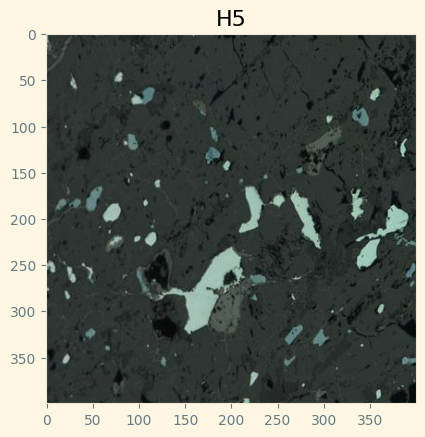

In [4]:
# Testing images from both sets, checking category :

plt.imshow(X_train[15])
plt.title(f"{y_train[15]}")
plt.grid(None)


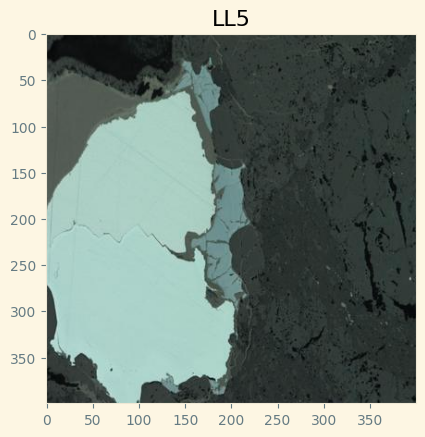

In [5]:
# Testing images from both sets :

plt.imshow(X_test[-1])
plt.title(f"{y_test[-1]}")
plt.grid(None)


In [6]:
# Encoding the layers (Keras likes numerical classes and we need to convert the str ones to int) :

number_classes = len(set(y_train))  # len of unique items in list, i.e. number of classes

le = LabelEncoder()  # Encoding as int for compatibility

y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

# Using keras one hot encoder, will use numpy argmax for most likely prediction
y_train_ohe = keras.utils.to_categorical(y_train_le, num_classes=number_classes)
y_test_ohe = keras.utils.to_categorical(y_test_le, num_classes=number_classes)


# 2 - Models definition :

## 2a - ImageNet weights :
- ImageNet is the largest image database and is the most commonly used for pretrained CNN feature extraction. It is a proven and reliable method, though it is not highly specialized for microscopic images.
- We will define and test three models:
  - VGG19
  - ResNet50
  - ResNet101
- The overall structure will be similar for all models, with only a few of the top layers unfrozen. A fully connected DNN with the following structure will be added:
512/256/128 units in successive layers, with 20% dropout applied at each stage.

### VGG : 

In [7]:
height = 400    
width = 400 
channels = 3

vgg19_imnet = keras.applications.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(height, width, channels)
    )

# Freezing the not trainable layers :
# We will alter training on specific layers in the next cell
vgg19_imnet.trainable = False


In [8]:
for i, layer in enumerate(vgg19_imnet.layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [9]:
# We want to unfreeze specifically the convolutional layers, not the pooling :
for layer in vgg19_imnet.layers[-4:-1]:
    layer.trainable = True


In [10]:
# Building Model :
vgg19_imnet_model = keras.Sequential()

vgg19_imnet_model.add(vgg19_imnet)

vgg19_imnet_model.add(keras.layers.Flatten())

vgg19_imnet_model.add(keras.layers.Dense(512, activation="relu"))
vgg19_imnet_model.add(keras.layers.Dropout(0.2))

vgg19_imnet_model.add(keras.layers.Dense(256, activation="relu"))
vgg19_imnet_model.add(keras.layers.Dropout(0.2))

vgg19_imnet_model.add(keras.layers.Dense(128, activation="relu"))
vgg19_imnet_model.add(keras.layers.Dropout(0.2))

# Output layer with softmax activation for multi-class classification
vgg19_imnet_model.add(keras.layers.Dense(number_classes, activation="softmax"))

optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Reduced learning rate

vgg19_imnet_model.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

vgg19_imnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 12, 12, 512)       20024384  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

### ResNet50 :

In [11]:
# Load ResNet50 with ImageNet weights, excluding the top fully connected layers
resnet50_imnet = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(height, width, channels)
)

# Freeze all layers by default, then unfreeze the last few layers
resnet50_imnet.trainable = False


In [12]:
for i, layer in enumerate(resnet50_imnet.layers[-20:]):
    print(i, layer.name, layer.trainable)


0 conv5_block2_1_conv False
1 conv5_block2_1_bn False
2 conv5_block2_1_relu False
3 conv5_block2_2_conv False
4 conv5_block2_2_bn False
5 conv5_block2_2_relu False
6 conv5_block2_3_conv False
7 conv5_block2_3_bn False
8 conv5_block2_add False
9 conv5_block2_out False
10 conv5_block3_1_conv False
11 conv5_block3_1_bn False
12 conv5_block3_1_relu False
13 conv5_block3_2_conv False
14 conv5_block3_2_bn False
15 conv5_block3_2_relu False
16 conv5_block3_3_conv False
17 conv5_block3_3_bn False
18 conv5_block3_add False
19 conv5_block3_out False


In [13]:
# Unfreezing the last few convolutional and batch norm layers (skip relu and add)
for layer in resnet50_imnet.layers[-15:]:
    if "conv" in layer.name or "bn" in layer.name:
        layer.trainable = True


In [14]:
# Build the full model
model_resnet50 = keras.Sequential()

model_resnet50.add(resnet50_imnet)

model_resnet50.add(keras.layers.GlobalAveragePooling2D())

# Add fully connected (dense) keras.layers with dropout for regularization
model_resnet50.add(keras.layers.Dense(512, activation="relu"))
model_resnet50.add(keras.layers.Dropout(0.2))

model_resnet50.add(keras.layers.Dense(256, activation="relu"))
model_resnet50.add(keras.layers.Dropout(0.2))

model_resnet50.add(keras.layers.Dense(128, activation="relu"))
model_resnet50.add(keras.layers.Dropout(0.2))

# Output layer for classification
model_resnet50.add(keras.layers.Dense(number_classes, activation="softmax"))

# reducing LR
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model_resnet50.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

model_resnet50.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

### ResNet101 : 

In [15]:
# Load ResNet101 with ImageNet weights, excluding the top fully connected layers
resnet101_imnet = keras.applications.ResNet101(
    weights="imagenet",
    include_top=False,
    input_shape=(height, width, channels)
)

resnet101_imnet.trainable = False


In [16]:
for i, layer in enumerate(resnet101_imnet.layers[-20:]):
    print(i, layer.name, layer.trainable)


0 conv5_block2_1_conv False
1 conv5_block2_1_bn False
2 conv5_block2_1_relu False
3 conv5_block2_2_conv False
4 conv5_block2_2_bn False
5 conv5_block2_2_relu False
6 conv5_block2_3_conv False
7 conv5_block2_3_bn False
8 conv5_block2_add False
9 conv5_block2_out False
10 conv5_block3_1_conv False
11 conv5_block3_1_bn False
12 conv5_block3_1_relu False
13 conv5_block3_2_conv False
14 conv5_block3_2_bn False
15 conv5_block3_2_relu False
16 conv5_block3_3_conv False
17 conv5_block3_3_bn False
18 conv5_block3_add False
19 conv5_block3_out False


In [17]:
# Unfreezing the last few convolutional and batch norm layers (skip relu and add)
for layer in resnet101_imnet.layers[-15:]:
    if "conv" in layer.name or "bn" in layer.name:
        layer.trainable = True


In [18]:
# Build the full model
model_resnet101 = keras.Sequential()

# Add the pre-trained ResNet101 base model
model_resnet101.add(resnet101_imnet)

model_resnet101.add(keras.layers.GlobalAveragePooling2D())

model_resnet101.add(keras.layers.Dense(512, activation="relu"))
model_resnet101.add(keras.layers.Dropout(0.2))

model_resnet101.add(keras.layers.Dense(256, activation="relu"))
model_resnet101.add(keras.layers.Dropout(0.2))

model_resnet101.add(keras.layers.Dense(128, activation="relu"))
model_resnet101.add(keras.layers.Dropout(0.2))

# Output layer for classification
model_resnet101.add(keras.layers.Dense(number_classes, activation="softmax"))

optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model_resnet101.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

# Model summary to inspect the architecture
model_resnet101.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 13, 13, 2048)      42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

# 3 : Models training
- Preprocessing data (specific to input model)
- Running 30 Epochs each
- Batch size 32 : faster runs and avoiding overfitting

## 3a - VGG19 :

In [19]:
# Using keras's vgg19 preprocessor to convert the images' arrays to the expected format

X_train_preprocessed = keras.applications.vgg19.preprocess_input(X_train)
X_test_preprocessed = keras.applications.vgg19.preprocess_input(X_test)


In [20]:
# early stop the model if validation loss doesnt improve in a 5 run span
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = vgg19_imnet_model.fit(
    X_train_preprocessed,
    y_train_ohe,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_preprocessed, y_test_ohe),
    callbacks=early_stopping
)


Epoch 1/30
215/215 [==============================] - 57s 218ms/step - loss: 2.3376 - accuracy: 0.3473 - val_loss: 1.1946 - val_accuracy: 0.5929
Epoch 2/30
215/215 [==============================] - 33s 152ms/step - loss: 1.1965 - accuracy: 0.6248 - val_loss: 0.8914 - val_accuracy: 0.6954
Epoch 3/30
215/215 [==============================] - 36s 168ms/step - loss: 0.7130 - accuracy: 0.7641 - val_loss: 0.6591 - val_accuracy: 0.8053
Epoch 4/30
215/215 [==============================] - 38s 176ms/step - loss: 0.4674 - accuracy: 0.8450 - val_loss: 0.6323 - val_accuracy: 0.8012
Epoch 5/30
215/215 [==============================] - 38s 175ms/step - loss: 0.3066 - accuracy: 0.9052 - val_loss: 0.6953 - val_accuracy: 0.8073
Epoch 6/30
215/215 [==============================] - 37s 174ms/step - loss: 0.2578 - accuracy: 0.9180 - val_loss: 0.6329 - val_accuracy: 0.8168
Epoch 7/30
215/215 [==============================] - 38s 175ms/step - loss: 0.2002 - accuracy: 0.9401 - val_loss: 0.6218 - val_ac

In [21]:
# Force the model to run on the CPU
with tf.device('/CPU:0'):
    # Saving VGG19 history
    vgg_history = history

    # Make predictions using CPU
    y_predict_ohe_vgg = vgg19_imnet_model.predict(X_test_preprocessed)

# Convert one-hot predictions to class indices
y_predict_vgg = np.argmax(y_predict_ohe_vgg, axis=1)


47/47 [==============================] - 535s 11s/step


In [22]:
# Frees up the GPU for new model training
del vgg19_imnet_model
gc.collect()
keras.backend.clear_session()


## 3b - ResNet50 :

In [23]:
# Using keras's resnet50 preprocessor to convert the images' arrays to the expected format

X_train_preprocessed = keras.applications.resnet50.preprocess_input(X_train)
X_test_preprocessed = keras.applications.resnet50.preprocess_input(X_test)


In [24]:
# early stop the model if validation loss doesnt improve in a 5 run span
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model_resnet50.fit(
    X_train_preprocessed,
    y_train_ohe,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_preprocessed, y_test_ohe),
    callbacks=early_stopping
)


Epoch 1/30
215/215 [==============================] - 31s 121ms/step - loss: 1.6785 - accuracy: 0.3659 - val_loss: 1.3459 - val_accuracy: 0.5441
Epoch 2/30
215/215 [==============================] - 18s 82ms/step - loss: 1.3407 - accuracy: 0.5049 - val_loss: 1.1337 - val_accuracy: 0.5889
Epoch 3/30
215/215 [==============================] - 18s 84ms/step - loss: 1.1617 - accuracy: 0.5640 - val_loss: 0.9911 - val_accuracy: 0.6309
Epoch 4/30
215/215 [==============================] - 19s 90ms/step - loss: 1.0421 - accuracy: 0.6143 - val_loss: 0.9118 - val_accuracy: 0.6696
Epoch 5/30
215/215 [==============================] - 19s 91ms/step - loss: 0.8982 - accuracy: 0.6681 - val_loss: 0.7719 - val_accuracy: 0.7307
Epoch 6/30
215/215 [==============================] - 19s 89ms/step - loss: 0.7871 - accuracy: 0.7126 - val_loss: 0.6987 - val_accuracy: 0.7544
Epoch 7/30
215/215 [==============================] - 19s 90ms/step - loss: 0.7160 - accuracy: 0.7475 - val_loss: 0.5983 - val_accuracy

In [25]:
# Saving resnet50 hist

# Force the model to run on the CPU
with tf.device('/CPU:0'):
    y_predict_ohe_resnet50 = model_resnet50.predict(X_test_preprocessed)
    resnet50_history = history

y_predict_resnet50 = np.argmax(y_predict_ohe_resnet50, axis=1)

# Frees up the GPU for new model training
del model_resnet50
gc.collect()
keras.backend.clear_session()


47/47 [==============================] - 209s 4s/step


## 3c : ResNet101

##### Sidenote : preprocessing between resnet50 and 101 should be the same so theres no need to rerun that

In [26]:
# early stop the model if validation loss doesnt improve in a 5 run span
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model_resnet101.fit(
    X_train_preprocessed,
    y_train_ohe,
    epochs=50,  # ResNet101 seems to benefit from a longer training period
    batch_size=16,
    validation_data=(X_test_preprocessed, y_test_ohe),
    callbacks=early_stopping
)


Epoch 1/50
215/215 [==============================] - 38s 147ms/step - loss: 1.6830 - accuracy: 0.3581 - val_loss: 1.3198 - val_accuracy: 0.5258
Epoch 2/50
215/215 [==============================] - 25s 115ms/step - loss: 1.3522 - accuracy: 0.5067 - val_loss: 1.1446 - val_accuracy: 0.5862
Epoch 3/50
215/215 [==============================] - 26s 119ms/step - loss: 1.1793 - accuracy: 0.5622 - val_loss: 1.0223 - val_accuracy: 0.6174
Epoch 4/50
215/215 [==============================] - 26s 121ms/step - loss: 1.0472 - accuracy: 0.6102 - val_loss: 0.8752 - val_accuracy: 0.6791
Epoch 5/50
215/215 [==============================] - 24s 113ms/step - loss: 0.9454 - accuracy: 0.6501 - val_loss: 0.7897 - val_accuracy: 0.7218
Epoch 6/50
215/215 [==============================] - 25s 119ms/step - loss: 0.8348 - accuracy: 0.6966 - val_loss: 0.7022 - val_accuracy: 0.7564
Epoch 7/50
215/215 [==============================] - 26s 123ms/step - loss: 0.7456 - accuracy: 0.7330 - val_loss: 0.6562 - val_ac

In [27]:
# Saving resnet101 hist

# Force the model to run on the CPU
with tf.device('/CPU:0'):
    y_predict_ohe_resnet101 = model_resnet101.predict(X_test_preprocessed)
    resnet101_history = history

y_predict_resnet101 = np.argmax(y_predict_ohe_resnet101, axis=1)

# Frees up the GPU
gc.collect()
keras.backend.clear_session()


47/47 [==============================] - 326s 7s/step


# 4 : Evaluation and possible adjusments
- The epochs logs are very promising, we will plot them and do a proper classification report to assess each model's capability

## 4.1 - VGG19

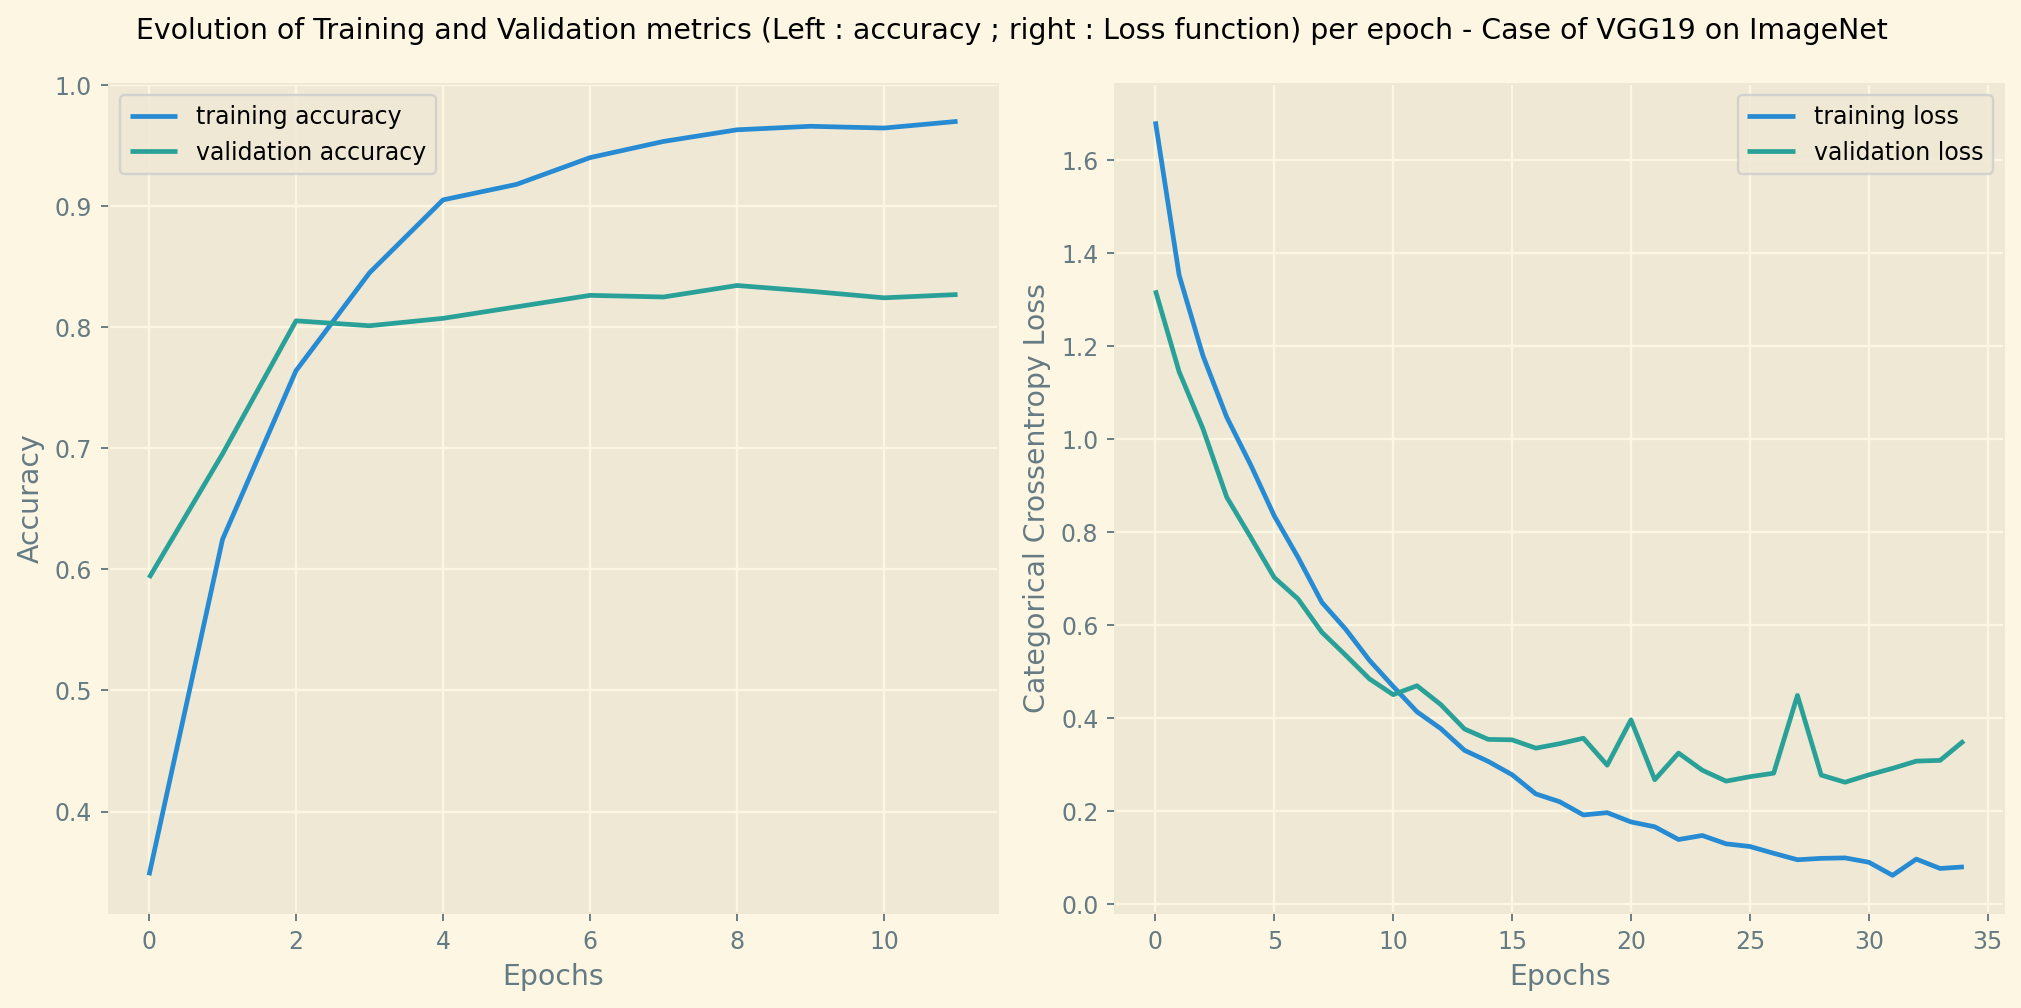

In [33]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

training_accuracy = vgg_history.history["accuracy"]
validation_accuracy = vgg_history.history["val_accuracy"]

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

ax1.plot(training_accuracy, label="training accuracy")
ax1.plot(validation_accuracy, label="validation accuracy")

ax2.plot(training_loss, label="training loss")
ax2.plot(validation_loss, label="validation loss")

###
# Titles/Lables
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Categorical Crossentropy Loss")
fig.suptitle("Evolution of Training and Validation metrics (Left : accuracy ; right : Loss function) per epoch - Case of VGG19 on ImageNet")
#
###

fig.tight_layout()
plt.show()


In [35]:
best_acccuracy_vgg = accuracy_score(y_true=y_test_le, y_pred=y_predict_vgg)

print(f"Best epoch for vgg19 model + DNN, pretrained on ImageNet is : {np.round(best_acccuracy_vgg * 100, decimals=4)}%")


Best epoch for vgg19 model + DNN, pretrained on ImageNet is : 82.6323%


In [36]:
inv_y_predict = le.inverse_transform(y_predict_vgg)
inv_true = le.inverse_transform(y_test_le)

# This reverses the encoding on labels
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict))


              precision    recall  f1-score   support

          H5       0.74      0.83      0.78       305
        H5-6       0.97      0.79      0.87       154
          H6       0.77      0.83      0.80       305
          L5       0.89      0.84      0.87       129
          L6       0.71      0.70      0.71       197
         LL5       0.94      0.91      0.93       240
         LL6       0.96      0.86      0.91       144

    accuracy                           0.83      1474
   macro avg       0.85      0.82      0.84      1474
weighted avg       0.83      0.83      0.83      1474



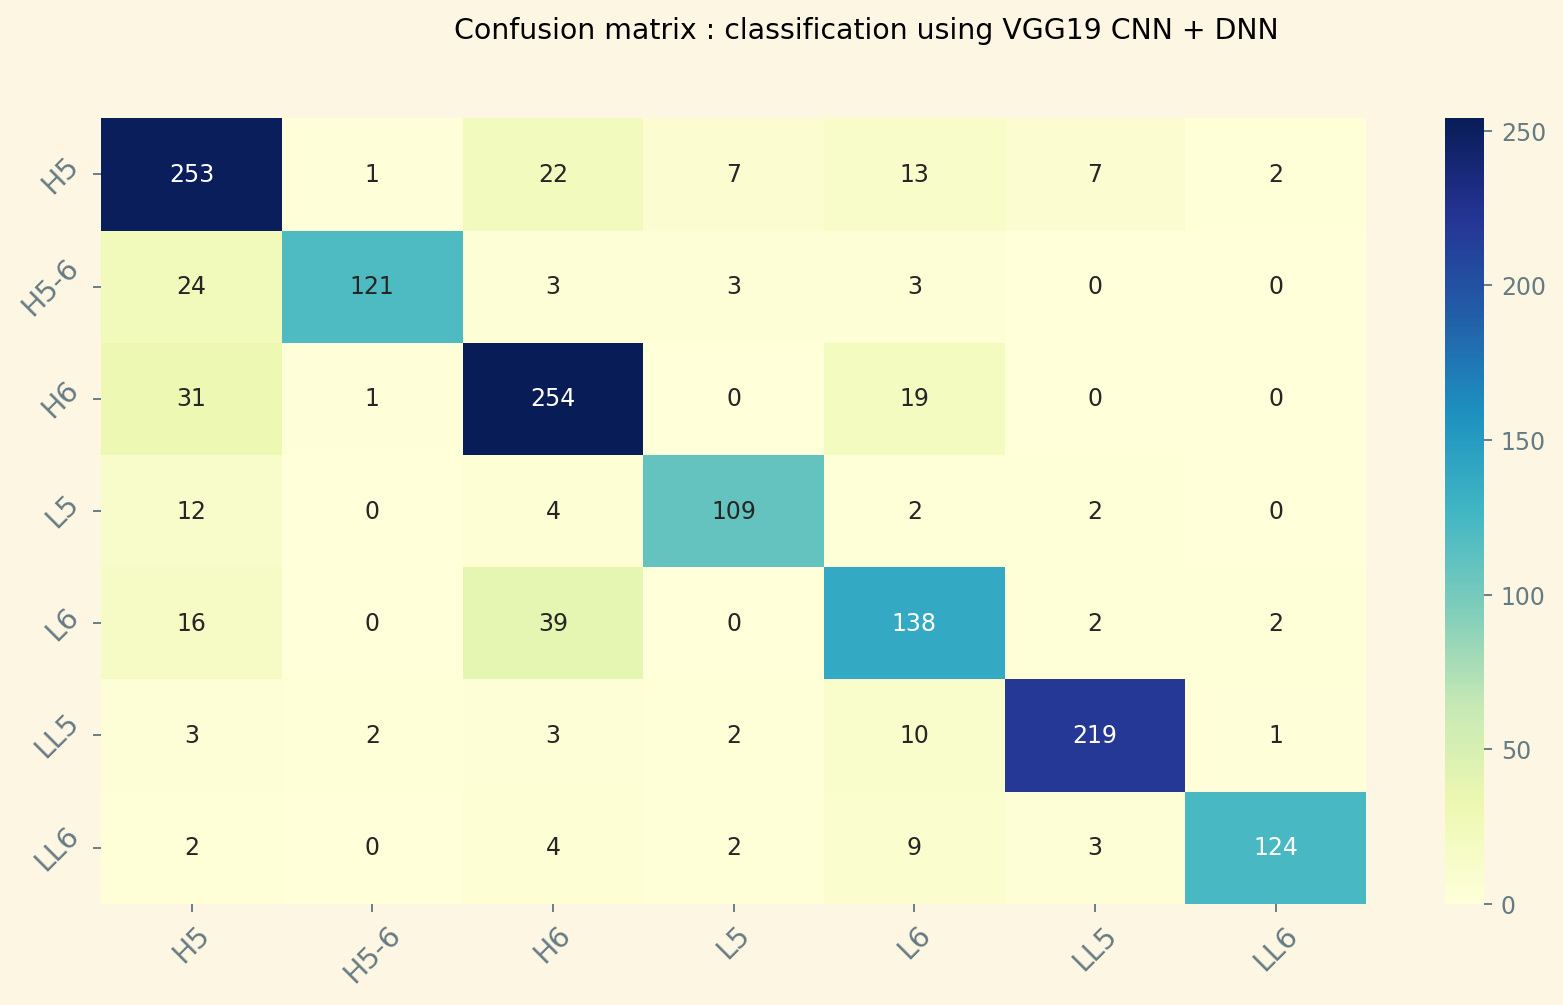

In [46]:
# Confusion matrix :

conf_matrix_vgg = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict))
conf_matrix_vgg.columns = le.inverse_transform(conf_matrix_vgg.columns)
conf_matrix_vgg.index = le.inverse_transform(conf_matrix_vgg.index)

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

sns.heatmap(conf_matrix_vgg, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True, fmt="d")

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=12)
fig.suptitle("Confusion matrix : classification using VGG19 CNN + DNN")
#
###

plt.show()

##### Oberservation :

- The VGG19 model pretrained on imagenet with 3 unfrozen layers + DNN classifier shows promising results, especially on a relatively small scale dataset such as ours.
- While accuracy in training keeps growing and training loss decreases, the validation metrics (the performances of the model on data isolated from the training process) plateaus at around epoch 8 where it seems we have our best metrics. Further epochs are likely prone to overfitting. This a however somewhat of a good news : this model manages to adhere quickly to the task and performs very well (82.63% validation accuracy on best epoch).
- The classification report shows that the model shines in categories such as LL5 (F1 score of .93), LL6 (F1 .91) while it seems to struggle with H6 and L6 objects. An expert opinion would likely offer valuable insights on the possible reasons why this is so.
- The confusion matrix shows misclassifications happen most frequently for L6 and L5, with some of those samples getting misclassified into other types, especially into neighboring categories like L6 to LL6 and L5 to LL5.


## 4.2 - ResNet50

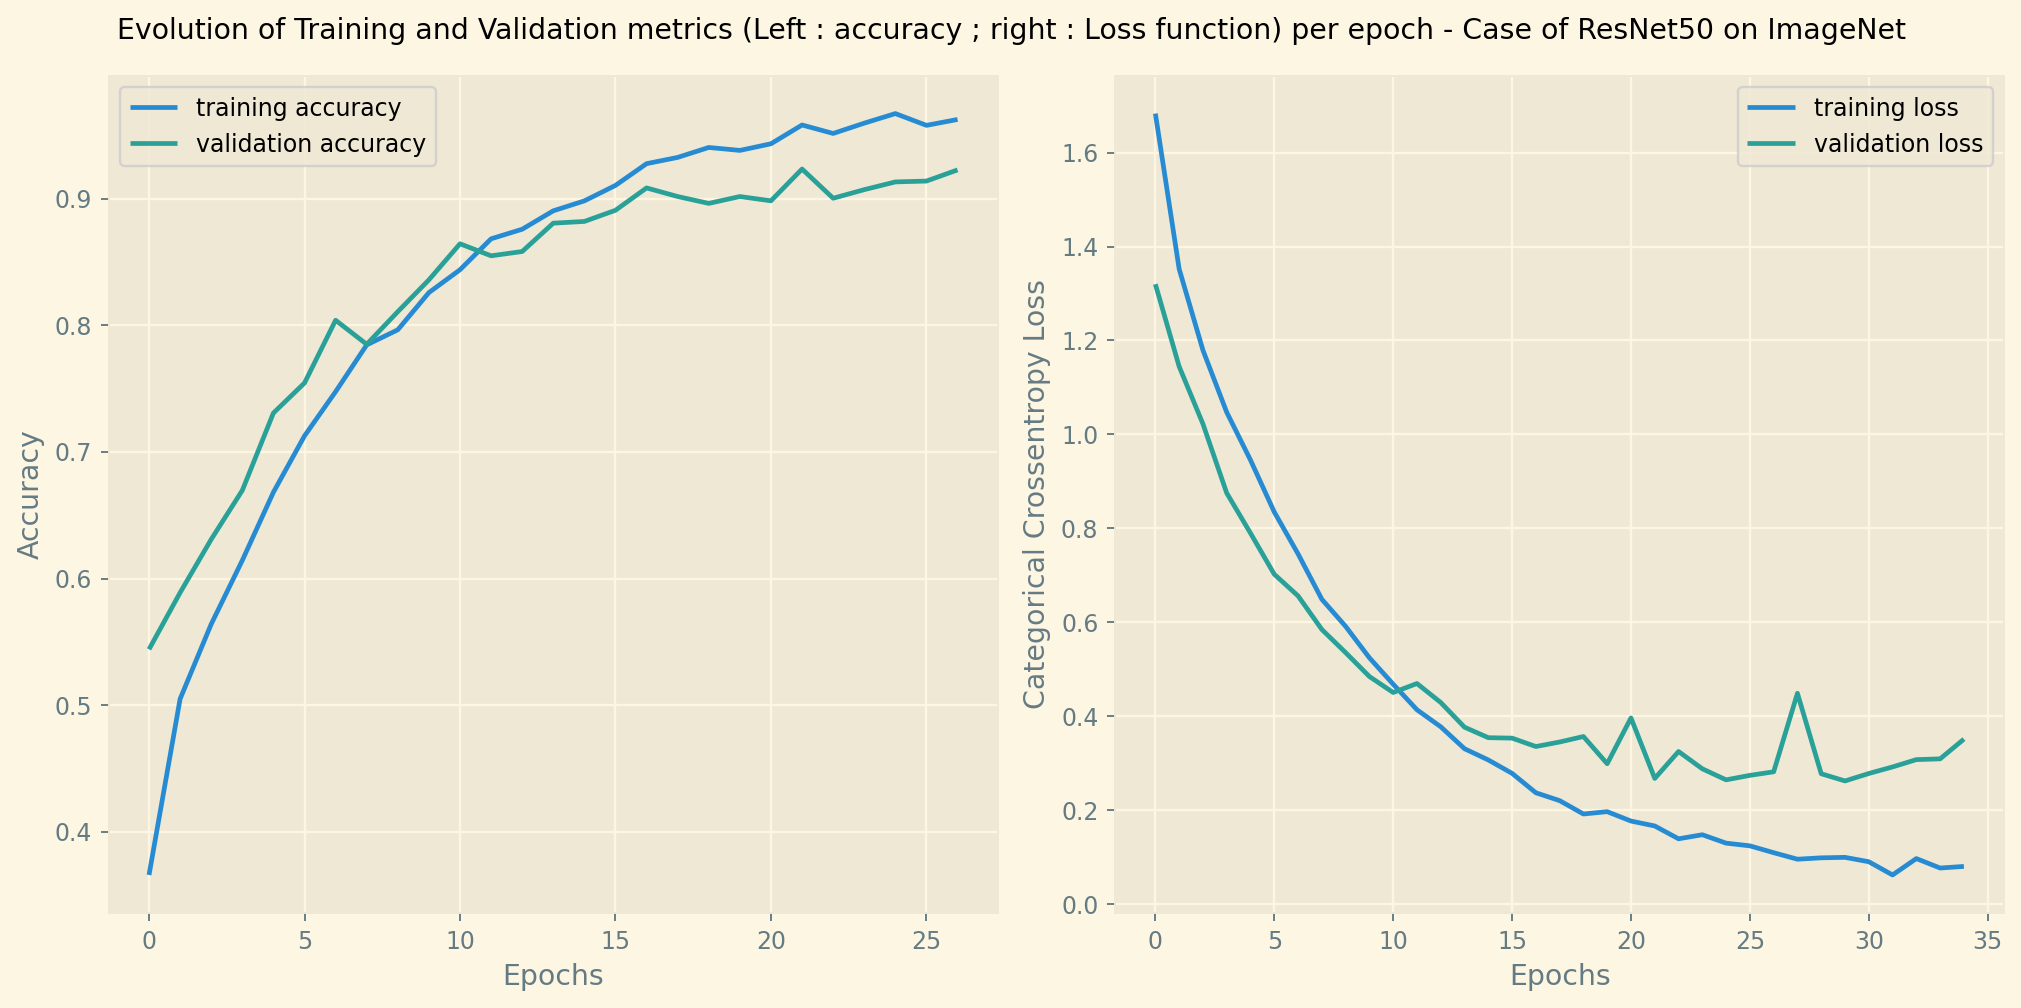

In [47]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

training_accuracy_res50 = resnet50_history.history["accuracy"]
validation_accuracy_res50 = resnet50_history.history["val_accuracy"]

training_loss_res50 = history.history["loss"]
validation_loss_res50 = history.history["val_loss"]

ax1.plot(training_accuracy_res50, label="training accuracy")
ax1.plot(validation_accuracy_res50, label="validation accuracy")

ax2.plot(training_loss_res50, label="training loss")
ax2.plot(validation_loss_res50, label="validation loss")

###
# Titles/Lables
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Categorical Crossentropy Loss")
fig.suptitle("Evolution of Training and Validation metrics (Left : accuracy ; right : Loss function) per epoch - Case of ResNet50 on ImageNet")
#
###

fig.tight_layout()
plt.show()


In [49]:
best_acccuracy_res50 = accuracy_score(y_true=y_test_le, y_pred=y_predict_resnet50)

print(f"Best epoch for ResNet50 model + DNN, pretrained on ImageNet is : {np.round(best_acccuracy_res50 * 100, decimals=4)}%")


Best epoch for ResNet50 model + DNN, pretrained on ImageNet is : 92.3338%


In [50]:
inv_y_predict_res50 = le.inverse_transform(y_predict_resnet50)
inv_true = le.inverse_transform(y_test_le)

# This reverses the encoding on labels
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict_res50))
    


              precision    recall  f1-score   support

          H5       0.91      0.88      0.89       305
        H5-6       0.94      0.96      0.95       154
          H6       0.91      0.88      0.90       305
          L5       0.96      0.95      0.95       129
          L6       0.88      0.89      0.88       197
         LL5       0.95      0.99      0.97       240
         LL6       0.96      0.97      0.97       144

    accuracy                           0.92      1474
   macro avg       0.93      0.93      0.93      1474
weighted avg       0.92      0.92      0.92      1474



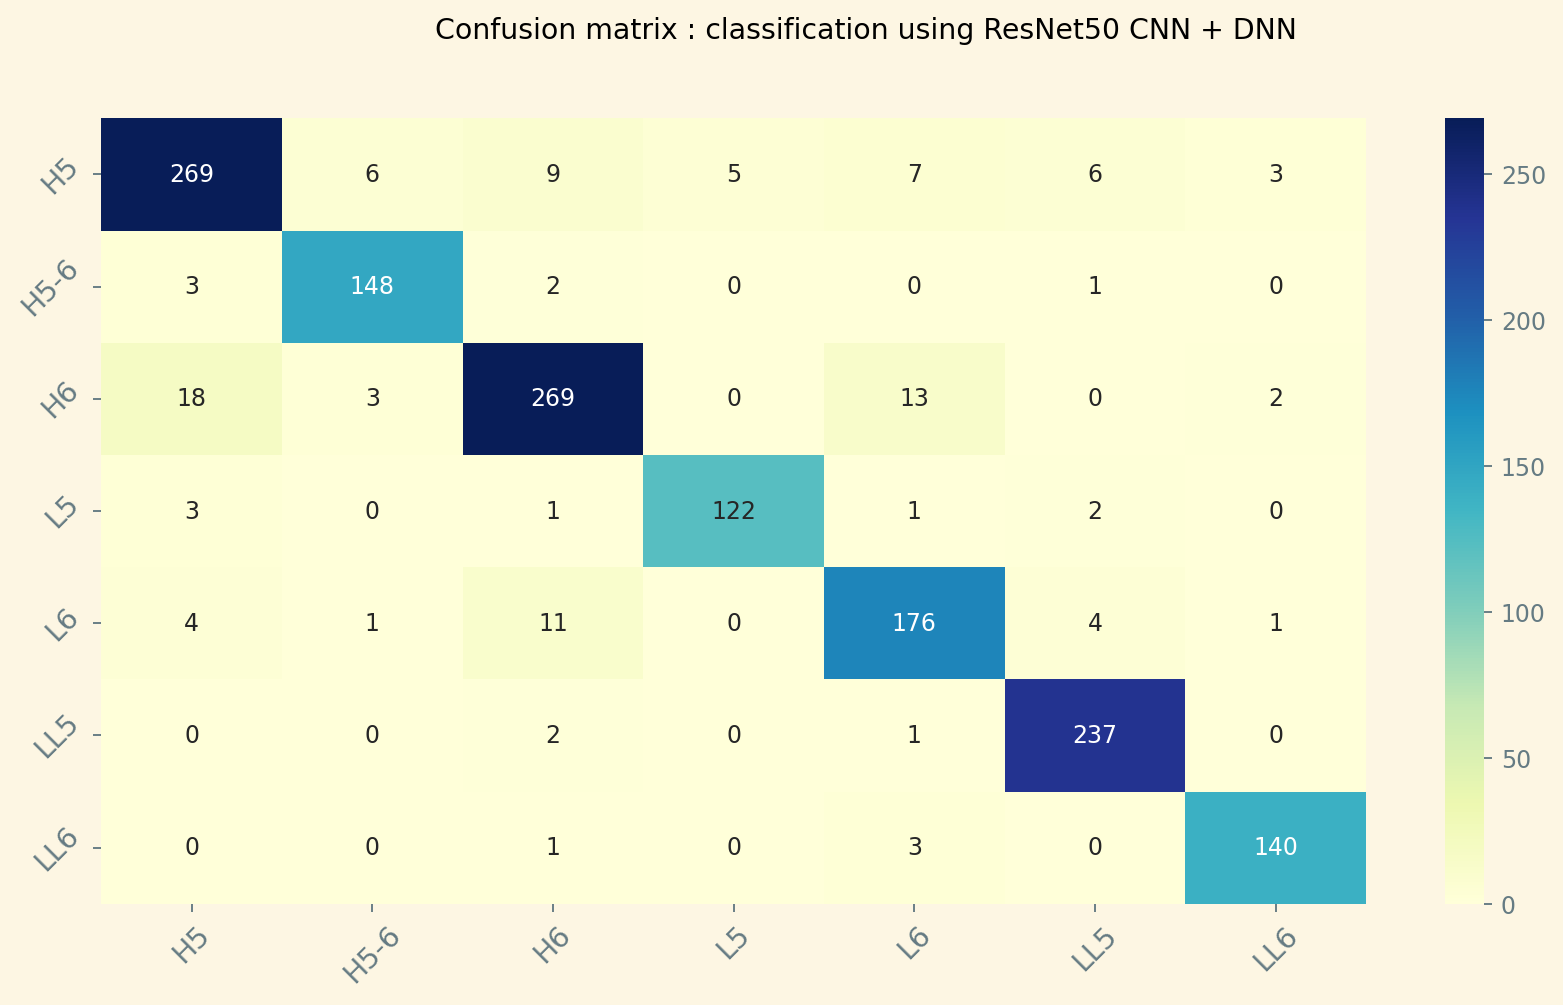

In [51]:
# Confusion matrix :

conf_matrix_res50 = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict_res50))
conf_matrix_res50.columns = le.inverse_transform(conf_matrix_res50.columns)
conf_matrix_res50.index = le.inverse_transform(conf_matrix_res50.index)

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

sns.heatmap(conf_matrix_res50, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True, fmt="d")

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=12)
fig.suptitle("Confusion matrix : classification using ResNet50 CNN + DNN")
#
###

plt.show()


##### Observations :
- ResNet50 model + DNN, pretrained on ImageNet:

- The ResNet50 model pretrained on ImageNet with a DNN classifier demonstrates outstanding performance on our dataset, far surpassing VGG19. With a best validation accuracy of 92.33%, it shows that this model is extremely well-suited for the classification task at hand.

- Similar to the VGG19 model, training accuracy and loss improve steadily. However, validation metrics (accuracy and loss) stay more tightly aligned with the training metrics, indicating that overfitting is well-controlled. The model reaches its peak performance around epoch 10, after which both the accuracy and loss curves plateau, showing minimal variance. This model clearly has an efficient and rapid learning curve.

- The classification report reflects the model’s general robustness across all categories. Notably, LL5 and LL6 are handled excellently with F1-scores of .95 and .97, respectively. The model also shows much-improved performance in challenging categories, with H6 achieving an F1-score of .89 and L6 an F1-score of .89, showing that ResNet50 resolves some of the weaknesses seen in the VGG19 model.

- The confusion matrix highlights very strong precision across categories, with relatively few misclassifications. Misclassifications happen, as expected, between L6 and LL6 and between H5 and H6—these are often neighboring categories in terms of features, but ResNet50 handles them better than VGG19 did.

**Conclusion:**
ResNet50 offers a significant improvement over VGG19, achieving higher accuracy and stronger per-class performance. Its ability to generalize across all categories makes it the clear winner in this proof of concept, demonstrating that it can classify meteorite types based on microscopic images with high reliability.


## 4.3 - ResNet101

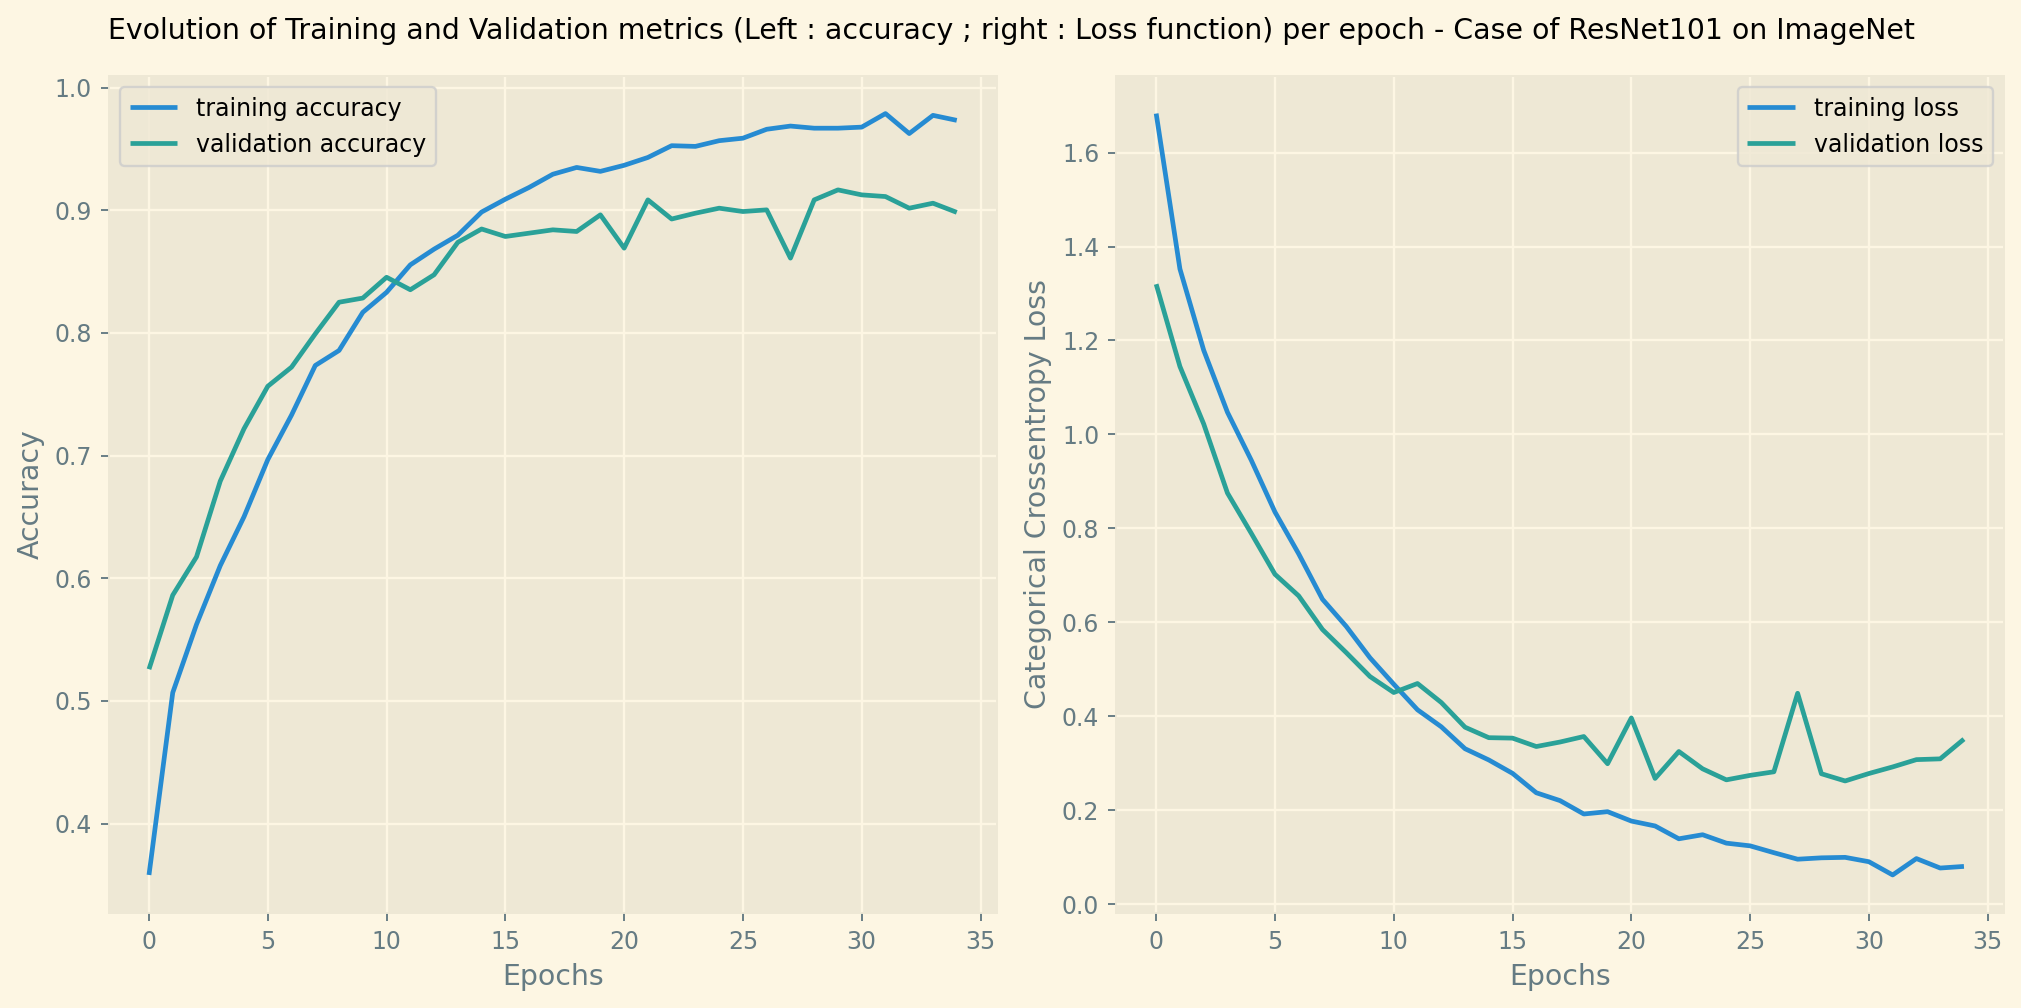

In [52]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

training_accuracy_res101 = resnet101_history.history["accuracy"]
validation_accuracy_res101 = resnet101_history.history["val_accuracy"]

training_loss_res101 = history.history["loss"]
validation_loss_res101 = history.history["val_loss"]

ax1.plot(training_accuracy_res101, label="training accuracy")
ax1.plot(validation_accuracy_res101, label="validation accuracy")

ax2.plot(training_loss_res101, label="training loss")
ax2.plot(validation_loss_res101, label="validation loss")

###
# Titles/Lables
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Categorical Crossentropy Loss")
fig.suptitle("Evolution of Training and Validation metrics (Left : accuracy ; right : Loss function) per epoch - Case of ResNet101 on ImageNet")
#
###

fig.tight_layout()
plt.show()


In [53]:
best_acccuracy_res101 = accuracy_score(y_true=y_test_le, y_pred=y_predict_resnet101)

print(f"Best epoch for vgg19 model + DNN, pretrained on ImageNet is : {np.round(best_acccuracy_res101 * 100, decimals=4)}%")


Best epoch for vgg19 model + DNN, pretrained on ImageNet is : 91.6554%


In [54]:
inv_y_predict_res101 = le.inverse_transform(y_predict_resnet101)
inv_true = le.inverse_transform(y_test_le)

# This reverses the encoding on labels
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict_res101))
    


              precision    recall  f1-score   support

          H5       0.89      0.87      0.88       305
        H5-6       0.88      0.91      0.89       154
          H6       0.90      0.88      0.89       305
          L5       0.93      0.95      0.94       129
          L6       0.93      0.89      0.91       197
         LL5       0.94      0.99      0.97       240
         LL6       0.96      0.97      0.97       144

    accuracy                           0.92      1474
   macro avg       0.92      0.92      0.92      1474
weighted avg       0.92      0.92      0.92      1474



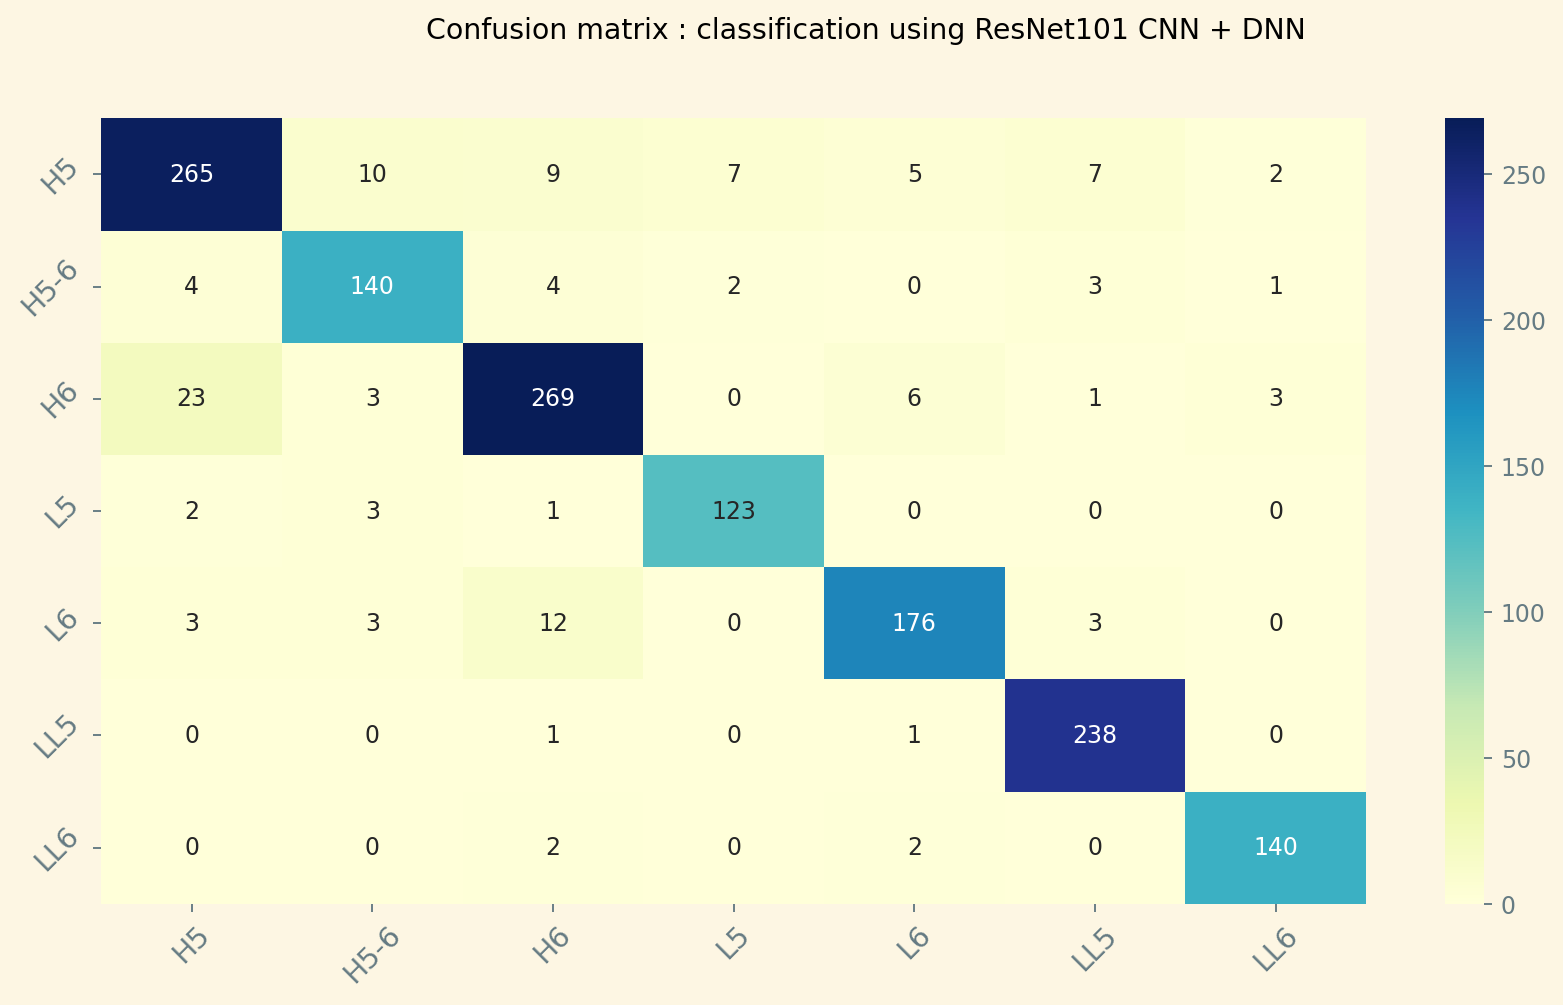

In [55]:
# Confusion matrix :

conf_matrix_res101 = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict_res101))
conf_matrix_res101.columns = le.inverse_transform(conf_matrix_res101.columns)
conf_matrix_res101.index = le.inverse_transform(conf_matrix_res101.index)

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=170,
)

sns.heatmap(conf_matrix_res101, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True, fmt="d")

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=12)
fig.suptitle("Confusion matrix : classification using ResNet101 CNN + DNN")
#
###

plt.show()


##### Observations :
- The ResNet101 model delivers excellent results similar to ResNet50, with a best validation accuracy of 91.66%. However, compared to ResNet50's 92.33%, we see that ResNet101 does not provide a significant boost in performance, despite being a larger model with more layers. This indicates that the added complexity may not yield much benefit for this dataset, where ResNet50 was already highly effective.

- The training and validation metrics show a steady increase in accuracy and decrease in loss, with both curves aligning quite closely up to around epoch 10-15, after which validation accuracy plateaus and the validation loss stabilizes. This suggests that ResNet101 learns rapidly and generalizes well on this dataset, but it doesn't offer a clear advantage over the lighter ResNet50.

- The classification report shows strong performance across all categories. H6, LL5, and LL6 continue to be well-classified with F1-scores above 0.90. The model's handling of H5 and L6 categories is also solid, with F1-scores of 0.89 and 0.88, respectively. The misclassifications are more balanced across categories compared to previous models, with fewer cases of high misclassification rates in specific categories.

- The confusion matrix reveals that misclassifications are somewhat evenly distributed across classes, though H5 and H6 categories still show some overlap. Notably, L5 and L6 show better separation than in the VGG19 and ResNet50 models. The model has some misclassification between H6 and L6, but overall, the confusion is more contained.

**Conclusion:**
ResNet101 provides strong classification performance but doesn't dramatically outperform ResNet50 despite the added complexity. It shows that ResNet50 is more than sufficient for this task, as the extra depth in ResNet101 doesn't seem necessary. The 91.66% accuracy is still impressive, but given the larger model size and training time, ResNet50 remains the most efficient and effective model for this task.

# <u>General conclusion</u>
## <u>Answers to the problematic, future insights and improvements, possibility of deployment and use in real-world conditions</u>

- A quick word on the models: the ResNet50 architecture with a couple unfrozen layers and a relatively simple DNN classifier seems to yield very impressive results. It is reasonable to think that a macro accuracy of 92+% can be considered high enough for deeper studies.
- The dataset is quite small and likely doesn't fully capture the whole span of microscopic meteorites' observations; but, even at this scale, it is quite clear that the model **can indeed** be of use to help identify the type of a given meteorite if provided with its microscopic photography
- It is not impossible to imagine that a very large dataset, regrouping microscopic observations from many scientists in that specific field, can be created. If that were to happen, it would be possible to train a CNN **from scratch** and **specifically trained for microscopical geology** - However, the size of the dataset would likely have to be north of 200K images and, at this time and to my knowledge, doesn't exist. One can however picture the possible benefits of such a tool for it would provide scientists with detailed insights and probabilistically realistic type inferences.
- The applications of such a model on a practical scale could be varied but one could for instance imagine a plugin in the microscope's interface software that may suggest the type of meteorite the scientist is observing with a high degree of certainty. The benefits of such a tool are interesting: while it doesn’t eliminate the necessity for further studies, it can both be used to gain time (spent on deeper analysis of the geochemical elements of the object) and resources (one may think it would alleviate some strain upon more specialized equipment and infrastructures necessary for deeper testing)
- Ultimately though, since these models, as with any models, are probabilistic and can never be 100% accurate, it wouldn't completely eliminate the need for such deeper studies, but could provide advice where and when the access or time to perform such analyses are bottlenecked
